# Initial Setup

## Imports

In [1]:
import math
import re
from IPython.display import Latex
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit import Qubit
from qiskit.providers.fake_provider import FakeCairo

## Global Variables

In [2]:
# Number of Qubits
N = 15

# IBMQ Mock Backend (https://qiskit.org/documentation/stable/0.42/apidoc/providers_fake_provider.html#fake-v1-backends)
backend = { 'device': FakeCairo() }
backend['name'] = re.sub(r'(_|fake|v\d)', ' ', backend['device'].backend_name.lower()).title()
backend['num_qubits'] = backend['device'].configuration().num_qubits
backend['simulator'] = AerSimulator.from_backend(backend['device'])

# Total Runs
shots = 1024

# linear GHZ container
linear = {
  'circuit': { 'draw': None, 'execute': None},
  'transpiled': None,
  'job': None,
  'result': None,
  'counts': { '0': None, '1': None },
  'time': None,
  'bias': { '0': None, '1': None },
  'error': None
}

# logarithmic GHZ container
log = {
  'circuit': { 'draw': None, 'execute': None},
  'transpiled': None,
  'job': None,
  'result': None,
  'counts': { '0': None, '1': None },
  'time': None,
  'bias': { '0': None, '1': None },
  'error': None
}

---

# Generate $|\text{GHZ}_N\rangle$ Circuits

## Generate Linear Time Complexity Circuits for $|\text{GHZ}_N\rangle$ $^\text{1}$

In [3]:
def linear_complexity_GHZ(N: int, measure: bool = True) -> QuantumCircuit:
  if not isinstance(N, int):
    raise TypeError("Only integer arguments accepted.")
  if N < 1:
    raise ValueError("There must be one or more qubits.")

  c = QuantumCircuit(N)
  c.h(0)
  for i in range(1, N):
    c.cx(i-1, i)
  if measure:
    c.measure_active()

  return c

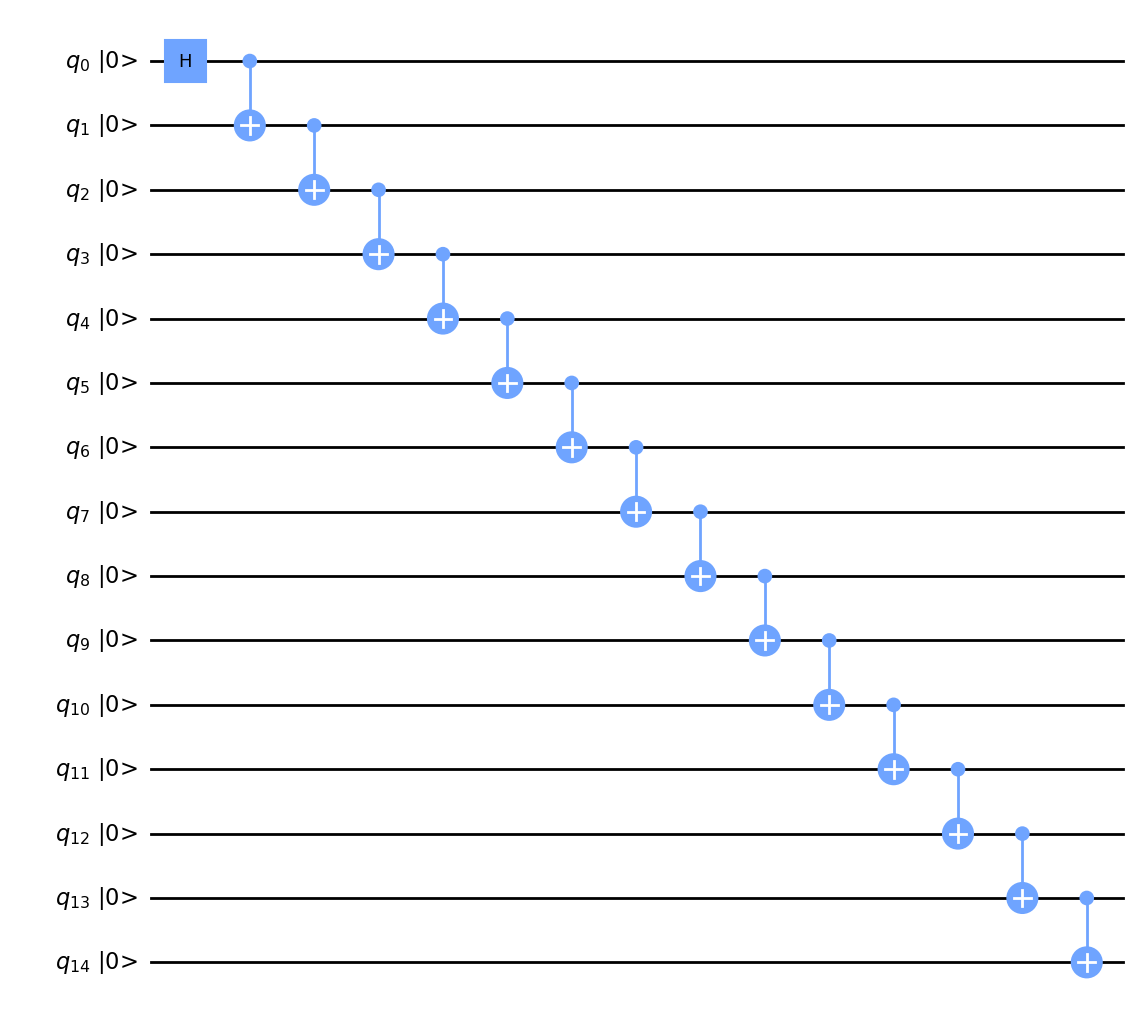

In [4]:
linear['circuit']['execute'] = linear_complexity_GHZ(N)
linear['circuit']['draw'] = linear_complexity_GHZ(N, False)
linear['circuit']['draw'].draw(output='mpl', fold=-1, initial_state=True)

## Generate Logaritmic Complexity Circuits for $|\text{GHZ}_{2^m}\rangle$ $^\text{1}$

In [5]:
def _log_complexity_GHZ(m: int) -> QuantumCircuit:
  if not isinstance(m, int):
    raise TypeError("Only integer arguments accepted.")
  if m < 0:
    raise ValueError("`m` must be at least 0 (evaluated 2^m).")

  if m == 0:
    c = QuantumCircuit([Qubit()])
    c.h(0)
    c.barrier()
  else:
    c = _log_complexity_GHZ(m - 1)
    for i in range(c.num_qubits):
      c.add_bits([Qubit()])
      new_qubit_index = c.num_qubits - 1
      c.cx(i, new_qubit_index)
    c.barrier()

  return c

## Generate Logaritmic Complexity Circuits for $|\text{GHZ}_N\rangle$ $^\text{1}$

In [6]:
def log_complexity_GHZ(N: int, measure: bool = True) -> QuantumCircuit:
  if not isinstance(N, int):
    raise TypeError("Only an integer argument is accepted.")
  if N < 1:
    raise ValueError("There must be one or more qubits.")

  m = math.ceil(math.log2(N))
  num_qubits_to_erase = 2**m - N
  old_circuit = _log_complexity_GHZ(m=m)
  new_num_qubits = old_circuit.num_qubits - num_qubits_to_erase
  new_circuit = QuantumCircuit(new_num_qubits)
  for gate in old_circuit.data:
    qubits_affected = gate.qubits
    if all(old_circuit.find_bit(qubit).index < new_num_qubits for qubit in qubits_affected):
      new_circuit.append(gate[0], [old_circuit.find_bit(qubit).index for qubit in qubits_affected])
  if measure:
    new_circuit.measure_active()

  return new_circuit

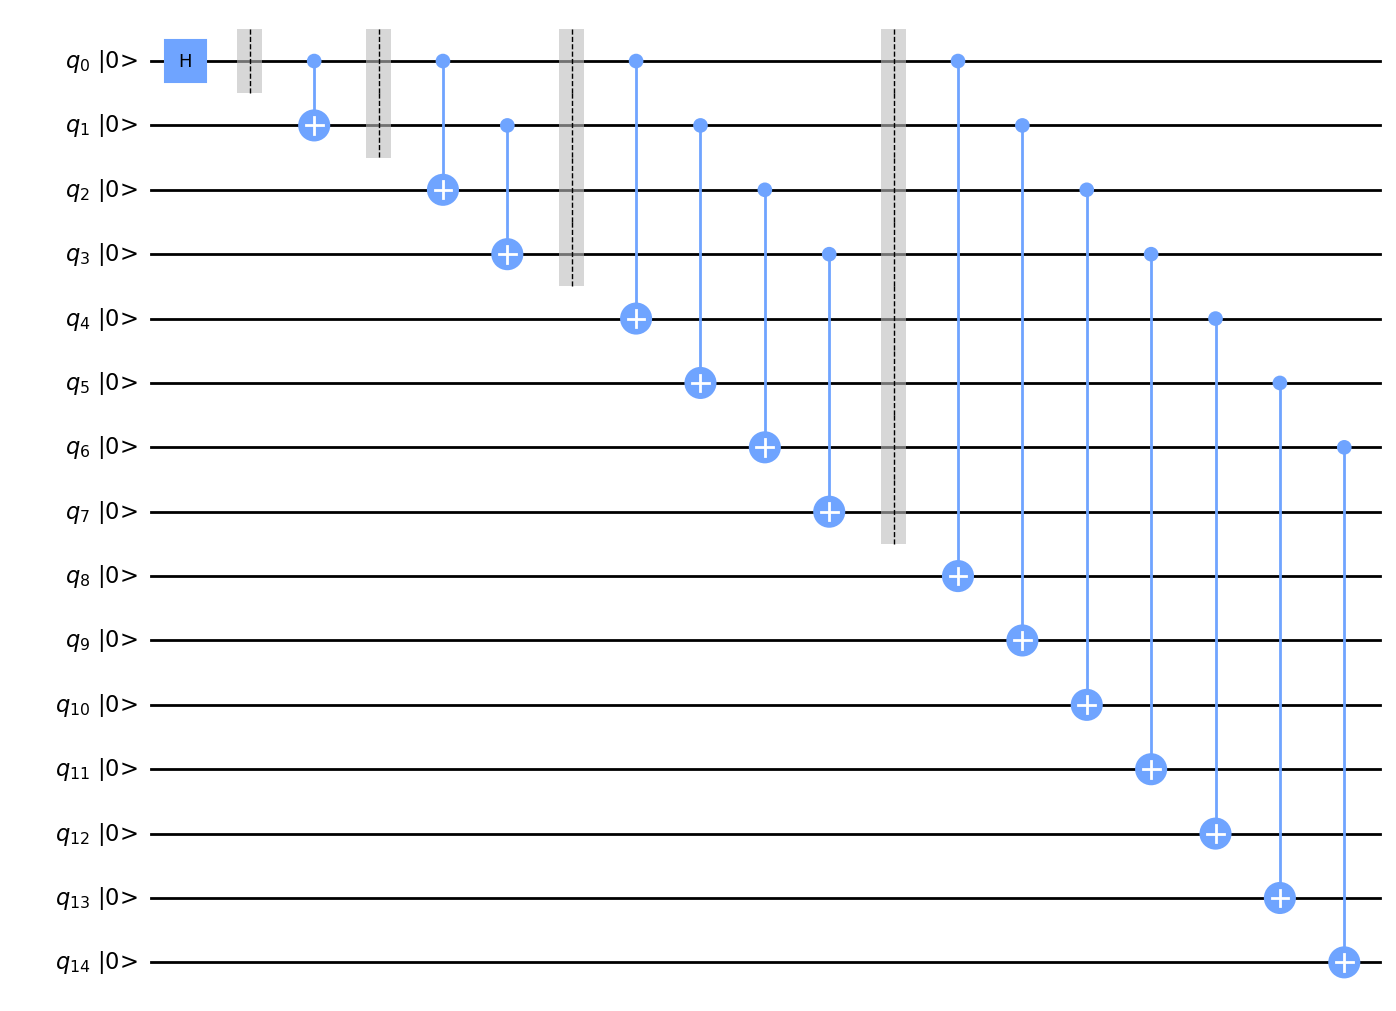

In [7]:
log['circuit']['execute'] = log_complexity_GHZ(N)
log['circuit']['draw'] = log_complexity_GHZ(N, False)
log['circuit']['draw'].draw(output='mpl', fold=-1, initial_state=True)

---

# Computational Cost Analysis

## Cost of Hadamard (H) Gate $^\text{2}$

In [8]:
H_cost = 2

## Cost of CNOT (CX) Gate $^\text{2}$

In [9]:
CX_cost = 5

## Program Cost

In [10]:
T_cost = ((N - 1) * CX_cost) + H_cost
Latex(f"""\\begin{{equation*}}{T_cost}\\end{{equation*}}""")

<IPython.core.display.Latex object>

## Program Sections (`s`)

In [11]:
def program_sections() -> int:
  init = [ 0, 1, 2 ]
  i = len(init)
  k = 1
  while len(init) <= N:
    init += [i] * 2**k
    i += 1
    k += 1
  return init[N]

In [12]:
s = program_sections()
Latex(f"""\\begin{{equation*}}{s}\\end{{equation*}}""")

<IPython.core.display.Latex object>

## Cost per Section

In [13]:
def cost_per_section() -> list:
  init = [ H_cost ]
  _N = N - 1
  k = 0
  while len(init) < (s - 1):
    init.append(CX_cost * 2**k)
    _N -= 2**k
    k += 1
  if _N > 0:
    init.append(CX_cost * _N)
  return init

In [14]:
section_cost_list = cost_per_section()
Latex(f"""\\begin{{equation*}}{section_cost_list}\\end{{equation*}}""")

<IPython.core.display.Latex object>

---

# Parallel v. Sequential Analysis in Logarithmic Circuit

## Gates Per Section

In [15]:
def gates_per_section() -> list:
  if s == 1:
    return [1]
  elif s == 2:
    return [1, 1]
  else:
    init = [1, 1]
    for i in range(len(init), s):
      init.append(int(section_cost_list[i] / CX_cost))
    return init

In [16]:
num_gates_list = gates_per_section()
Latex(f"""\\begin{{equation*}}{num_gates_list}\\end{{equation*}}""")

<IPython.core.display.Latex object>

## Percent Sequential

In [17]:
def add_sequential_portions() -> float:
  seq = 0
  for cost, gates in zip(section_cost_list, num_gates_list):
    seq += (1 / gates) * (cost / T_cost)
  return seq

In [18]:
sequential_portion = add_sequential_portions()
Latex(f"""\\begin{{equation*}}{sequential_portion * 100}\%\\end{{equation*}}""")

<IPython.core.display.Latex object>

## Percent Parallel

In [19]:
def add_parallel_portions() -> float:
  par = 0
  for cost, gates in zip(section_cost_list, num_gates_list):
    par += ( (gates - 1) / gates ) * (cost / T_cost)
  return par

In [20]:
parallel_portion = add_parallel_portions()
Latex(f"""\\begin{{equation*}}{parallel_portion * 100}\%\\end{{equation*}}""")

<IPython.core.display.Latex object>

---

# Quantum Simulation

## Device

In [21]:
Latex(f"""\\begin{{equation*}}
          \\text{{{backend['name']} ({backend['num_qubits']} qubits)}}
          \\end{{equation*}}""")

<IPython.core.display.Latex object>

## Transpile Circuits $^\text{3}$

In [22]:
linear['transpiled'] = transpile(linear['circuit']['execute'],
                                 backend['simulator'],
                                 scheduling_method="asap",
                                 optimization_level=0)

In [23]:
log['transpiled'] = transpile(log['circuit']['execute'],
                              backend['simulator'],
                              scheduling_method="asap",
                              optimization_level=0)

## Run Simulations

In [24]:
linear['job'] = backend['device'].run(linear['transpiled'])

In [25]:
log['job'] = backend['device'].run(log['transpiled'])

## Block for Results

In [26]:
linear['result'] = linear['job'].result()

In [27]:
log['result'] = log['job'].result()

---

# Speed-Up Analysis

## Run-Times

### Linear

In [28]:
linear['time'] = linear['result'].time_taken
Latex(f"""\\begin{{equation*}}{linear['time']}\space\\text{{seconds}}\\end{{equation*}}""")

<IPython.core.display.Latex object>

### Logarithmic

In [29]:
log['time'] = log['result'].time_taken
Latex(f"""\\begin{{equation*}}{log['time']}\space\\text{{seconds}}\\end{{equation*}}""")

<IPython.core.display.Latex object>

## Theoretical Max Speed-Up (Amdahl's Law $^\text{4}$)

$$S_{\text{latency}} = \lim_{F\to\infty} \dfrac{1}{S_{\text{eq}} + \dfrac{P}{F}} = \dfrac{1}{S_{\text{eq}}}$$

- $S_{\text{eq}}$ represents the portions of the program running sequentially
- $P$ represents the portions of the program running in parallel
- $F$ represents the level of concurrency (i.e. number of cores in classical computing)

In [30]:
Latex(f"""\\begin{{equation*}}{1 / sequential_portion}\\end{{equation*}}""")

<IPython.core.display.Latex object>

## Observed Speed-Up Factor ($S_{\text{latency}}$)

In [31]:
S_latency = linear['time'] / log['time']
Latex(f"""\\begin{{equation*}}{S_latency}\\end{{equation*}}""")

<IPython.core.display.Latex object>

## Approximated Level of Concurrency ($F$)

$$F = \dfrac{P\cdot S_{\text{latency}}}{1 - S_{\text{eq}}\cdot S_{\text{latency}}}$$

In [32]:
F = (parallel_portion * S_latency) / (1 - (sequential_portion * S_latency))
Latex(f"""\\begin{{equation*}}{F}\\end{{equation*}}""")

<IPython.core.display.Latex object>

---

# Error & Bias Analysis

## Get Counts

In [33]:
try:
  linear['counts']['0'] = linear['result'].get_counts()['0' * N]
except KeyError:
  linear['counts']['0'] = 0
try:
  linear['counts']['1'] = linear['result'].get_counts()['1' * N]
except KeyError:
  linear['counts']['1'] = 0
try:
  log['counts']['0'] = log['result'].get_counts()['0' * N]
except KeyError:
  log['counts']['0'] = 0
try:
  log['counts']['1'] = log['result'].get_counts()['1' * N]
except KeyError:
  log['counts']['1'] = 0

## Error

### Linear Error Percent

In [34]:
linear['error'] = (shots - (linear['counts']['0'] + linear['counts']['1'])) / shots
Latex(f"""\\begin{{equation*}}{linear['error'] * 100}\%\\end{{equation*}}""")

<IPython.core.display.Latex object>

### Logarithmic Error Percent

In [35]:
log['error'] = (shots - (log['counts']['0'] + log['counts']['1'])) / shots
Latex(f"""\\begin{{equation*}}{log['error'] * 100}\%\\end{{equation*}}""")

<IPython.core.display.Latex object>

## Bias

### Linear Bias Percent

#### State $|0\rangle$

In [36]:
linear['bias']['0'] = linear['counts']['0'] / (linear['counts']['0'] + linear['counts']['1'])
Latex(f"""\\begin{{equation*}}{linear['bias']['0'] * 100}\%\\end{{equation*}}""")

<IPython.core.display.Latex object>

#### State $|1\rangle$

In [37]:
linear['bias']['1'] = linear['counts']['1'] / (linear['counts']['0'] + linear['counts']['1'])
Latex(f"""\\begin{{equation*}}{linear['bias']['1'] * 100}\%\\end{{equation*}}""")

<IPython.core.display.Latex object>

### Logarithmic Bias Percent

#### State $|0\rangle$

In [38]:
log['bias']['0'] = log['counts']['0'] / (log['counts']['0'] + log['counts']['1'])
Latex(f"""\\begin{{equation*}}{log['bias']['0'] * 100}\%\\end{{equation*}}""")

<IPython.core.display.Latex object>

#### State $|1\rangle$

In [39]:
log['bias']['1'] = log['counts']['1'] / (log['counts']['0'] + log['counts']['1'])
Latex(f"""\\begin{{equation*}}{log['bias']['1'] * 100}\%\\end{{equation*}}""")

<IPython.core.display.Latex object>

---

# References

1. [Cruz, Diogo, Romain Fournier, Fabien Gremion, Alix Jeannerot, Kenichi Komagata, Tara Tosic, Jarla Thiesbrummel, et al. (2018). Efficient Quantum Algorithms for $GHZ$ and $W$ States, and Implementation on the IBM Quantum Computer. ArXiv. 1-2.](https://doi.org/10.48550/ARXIV.1807.05572)

2. [Lee, Soonchil & Lee, Seong-Joo & Kim, Taegon & Lee, Jae-Seung & Biamonte, Jacob & Perkowski, Marek. (2006). The cost of quantum gate primitives. Journal of Multiple-Valued Logic and Soft Computing. 12. 571.](https://www.researchgate.net/publication/216778423_The_cost_of_quantum_gate_primitives)

3. [Scheduling Methods](https://qiskit.org/documentation/stable/0.42/tutorials/circuits_advanced/07_pulse_scheduler.html#Scheduler-methods)

4. [Amdahl's Law Definition](https://en.wikipedia.org/wiki/Amdahl%27s_law#Definition)